In [1]:
import tensorflow as tf
import malaya_speech
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import malaya_speech.augmentation.waveform as augmentation

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
from glob import glob

files = glob('../youtube/clean-wav/*.wav')
len(files)

15385

In [4]:
import random

def combine_speakers(files, n = 5):
    w_samples = random.sample(files, n)
    y = [w_samples[0]]
    left = w_samples[0].copy()
    for i in range(1, n):

        right = w_samples[i].copy()

        overlap = random.uniform(0.01, 1.5)
        left_len = int(overlap * len(left))

        padded_right = np.pad(right, (left_len, 0))

        if len(left) > len(padded_right):
            padded_right = np.pad(
                padded_right, (0, len(left) - len(padded_right))
            )
        else:
            left = np.pad(left, (0, len(padded_right) - len(left)))

        y.append(padded_right)
        left = left + padded_right
    return left, y

In [5]:
y, sr = malaya_speech.load(files[0], sr = 44100)
y = y[:sr * 10]
y = y.astype(np.float32)
len(y) / sr / 60, sr

(0.16666666666666666, 44100)

In [6]:
y1, sr = malaya_speech.load(files[-1], sr = 44100)
y1 = y1[:sr * 10]
y1 = y1.astype(np.float32)
len(y1) / sr / 60, sr

(0.16666666666666666, 44100)

In [7]:
combined = y + y1
combined = combined / np.max(np.abs(combined))
Y = [y, y1]

/home/husein/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/husein/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


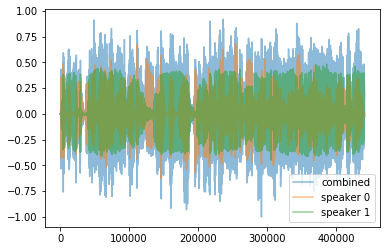

In [8]:
plt.plot(combined, alpha = 0.5, label = 'combined')
for no, i in enumerate(Y):
    plt.plot(i, alpha = 0.5, label = f'speaker {no}')
plt.legend()

In [9]:
def pad_and_partition(tensor, segment_len):
    tensor_size = tf.math.floormod(tf.shape(tensor)[0], segment_len)
    pad_size = tf.math.floormod(segment_len - tensor_size, segment_len)
    padded = tf.pad(
        tensor,
        [[0, pad_size]] + [[0, 0]] * (len(tensor.shape)-1))
    split = (tf.shape(padded)[0] + segment_len - 1) // segment_len
    return tf.reshape(
        padded,
        tf.concat(
            [[split, segment_len], tf.shape(padded)[1:]],
            axis=0))

In [22]:
from tensorflow.signal import stft, inverse_stft, hann_window

def get_stft(y, return_magnitude = True, frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    
    waveform = tf.concat([
        tf.zeros((frame_length, 1)),
        tf.expand_dims(y, -1)
    ], 0
    )
    stft_feature = tf.transpose(
        stft(
            tf.transpose(waveform),
            frame_length,
            frame_step,
            window_fn=lambda frame_length, dtype: (
                hann_window(frame_length, periodic=True, dtype=dtype)),
            pad_end=True),
        perm=[1, 2, 0])
    if return_magnitude:
        D = tf.abs(pad_and_partition(stft_feature, T))[:, :, :F, :]
        return stft_feature, D
    else:
        return stft_feature
    
def istft(stft_t, y, time_crop=None, factor = 2 / 3,
                frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    
    inversed = inverse_stft(
        tf.transpose(stft_t, perm=[2, 0, 1]),
        frame_length,
        frame_step,
        window_fn=lambda frame_length, dtype: (
            hann_window(frame_length, periodic=True, dtype=dtype))
    ) * factor
    reshaped = tf.transpose(inversed)
    if time_crop is None:
        time_crop = tf.shape(y)[0]
    return reshaped[frame_length:frame_length+time_crop, :]

In [13]:
stft_combined, D_combined = get_stft(combined)
stft_y, D_y = get_stft(y)
stft_y1, D_y1 = get_stft(y1)

In [14]:
tf.reduce_min(D_y), tf.reduce_max(D_y)

(<tf.Tensor: id=546, shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: id=548, shape=(), dtype=float32, numpy=147.31418>)

In [15]:
D_combined.shape, D_y.shape, D_y1.shape

(TensorShape([Dimension(1), Dimension(512), Dimension(1024), Dimension(1)]),
 TensorShape([Dimension(1), Dimension(512), Dimension(1024), Dimension(1)]),
 TensorShape([Dimension(1), Dimension(512), Dimension(1024), Dimension(1)]))

In [24]:
def pad_and_reshape(instr_spec, frame_length, frame_step = 1024, T = 512, F = 1024):
    """
    :param instr_spec:
    :param frame_length:
    :param F:
    :returns:
    """
    spec_shape = tf.shape(instr_spec)
    extension_row = tf.zeros((spec_shape[0], spec_shape[1], 1, spec_shape[-1]))
    n_extra_row = (frame_length) // 2 + 1 - F
    extension = tf.tile(extension_row, [1, 1, n_extra_row, 1])
    extended_spec = tf.concat([instr_spec, extension], axis=2)
    old_shape = tf.shape(extended_spec)
    new_shape = tf.concat([
        [old_shape[0] * old_shape[1]],
        old_shape[2:]],
        axis=0)
    processed_instr_spec = tf.reshape(extended_spec, new_shape)
    return processed_instr_spec

def _extend_mask(mask, extension = 'zeros', frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    if extension == "average":
        extension_row = tf.reduce_mean(mask, axis=2, keepdims=True)
    # Extend with 0
    # (avoid extension artifacts but not conservative separation)
    elif extension == "zeros":
        mask_shape = tf.shape(mask)
        extension_row = tf.zeros((
            mask_shape[0],
            mask_shape[1],
            1,
            mask_shape[-1]))
    else:
        raise ValueError(f'Invalid mask_extension parameter {extension}')
    n_extra_row = frame_length // 2 + 1 - F
    extension = tf.tile(extension_row, [1, 1, n_extra_row, 1])
    return tf.concat([mask, extension], axis=2)

In [25]:
separation_exponent = 2
EPSILON = 1e-10

output_sum = tf.reduce_sum(
        [D_y ** separation_exponent, D_y1 ** separation_exponent],
        axis=0) + EPSILON

r = {}
for no, D in enumerate([D_y, D_y1]):

    instrument_mask = (D ** separation_exponent + (EPSILON / 2)) / output_sum
    instrument_mask = _extend_mask(instrument_mask)
    old_shape = tf.shape(instrument_mask)
    new_shape = tf.concat(
        [[old_shape[0] * old_shape[1]], old_shape[2:]],
        axis=0)
    instrument_mask = tf.reshape(instrument_mask, new_shape)

    instrument_mask = instrument_mask[:tf.shape(stft_combined)[0], ...]
    masked_stft = tf.cast(instrument_mask, dtype=tf.complex64) * stft_combined
    r[no] = istft(masked_stft, y1)[:,0].numpy()

In [26]:
ipd.Audio(r[0], rate = sr)

In [27]:
ipd.Audio(r[1], rate = sr)

In [ ]:
ipd.Audio(inverse_stft(stft_y)[:,0].numpy(), rate = sr)

In [ ]:
ipd.Audio(inverse_stft(stft_y1)[:,0].numpy(), rate = sr)